Find the markdown blocks that say interaction required! The notebook should take care of the rest!

# Import libs

In [1]:
import sys
import os
sys.path.append('..')
from eflow.foundation import DataPipeline,DataFrameTypes
from eflow.data_analysis import FeatureAnalysis, NullAnalysis
from eflow.model_analysis import ClassificationAnalysis
from eflow.data_pipeline_segments import FeatureTransformer, TypeFixer, DataEncoder
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline, remove_unconnected_pipeline_segments
from eflow.utils.math_utils import get_unbalanced_threshold
from eflow.utils.sys_utils import create_dir_structure
from eflow.utils.eflow_utils import create_color_dict_for_features
from eflow.utils.pandas_utils import data_types_table, value_counts_table, suggest_removal_features 

import pandas as pd
import numpy as np
import scikitplot as skplt
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import copy
from IPython.display import clear_output
from IPython.core.getipython import get_ipython
import ipython_blocking
import nltk

In [2]:
# # Additional add ons
# !pip install pandasgui
# !pip install pivottablejs
# clear_output()

In [3]:
%matplotlib notebook
%matplotlib inline

## Juypter notebook generating cells

### Important Note: Replace if set to True will remove all the contents of whatever cell it is called in. But it can be undone with a simple CMD + Z. 🙂

In [4]:
# Author: http://tinyurl.com/y6mghyzl
def create_new_cell(contents,
                    replace=False):
    """
    Desc:
        Creates a new jupyter cell.
    """
    shell = get_ipython()
    shell.set_next_input(contents,
                         replace=replace)

def __format_list_to_string(list_name,
                            list_contents):
    """
    Desc:
        Converts a list to a string and adds newlines for formating.
    """
    output_str = f"{list_name} = ["
    escape_seq_count = 0
    final_index = len(list_contents) - 1
    req_spacing = len(output_str)

    for i,element in enumerate(list_contents):
        if i == final_index:
            output_str += f'\"{element}\"'
        else:
            output_str += f'\"{element}\",'
        
        if len(output_str.split("\n")[escape_seq_count]) > 78:
            output_str += "\n"
            output_str += (" " * req_spacing)
            escape_seq_count += 1
    output_str += "]"
    return output_str

def create_new_cell_with_removal_features(df,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove.
    
    Args:
        df:
            Pandas DataFrame object
            
        replace:
            Boolean to determine replacing the current cell.
    """
    
    # Get suggestions for removal
    cell_content = __format_list_to_string("removal_features",
                                           suggest_removal_features(df))
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_removal_features(df,replace={replace})\n" + cell_content
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_null_removal_features(df,
                                               null_threshold=.25,
                                               replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove based on nulls.
    
    Args:
        df:
            Pandas DataFrame object
            
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() / len(df)

    cell_content = __format_list_to_string("remove_null_features",
                                            mis_val_percent[mis_val_percent > null_threshold].index.to_list())
    # Add a calling card of the function that created it
    cell_content += f"# create_new_cell_with_null_removal_features(df,null_threshold={null_threshold},replace={replace})\n"
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_feature_value_color_dict(df,
                                                  df_features,
                                                  value_limit=50,
                                                  replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object
        
        df_features:
            DataFrameTypes object.
        
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_color_dict = create_color_dict_for_features(df,
                                                              df_features,
                                                              value_limit)
    # Add a sort of calling card of the function that created it
    cell_content = ""
    cell_content += f"# create_new_cell_with_feature_value_color_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "feature_value_color_dict=dict()"
    feature_count = 0
    for feature_name, feature_value_color in feature_value_color_dict.items():
        if feature_value_color_dict[feature_name].keys(): 
            cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"] = dict()"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give colors to each!"
        
        for feature_value, color in feature_value_color.items():

            color = feature_value_color_dict[feature_name][feature_value]
            
            if isinstance(feature_value,str):
                feature_value = f"\"{feature_value}\""
            else:
                feature_value = f"{feature_value}"
            
            if color is None:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = None"
            else:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = \"{color}\""
        cell_content += "\n"
        
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_categorical_dict(df,
                                          df_features,
                                          value_limit=50,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a dict of
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """

    cell_content = ""
    cell_content += f"# create_new_cell_with_categorical_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "categorical_value_dict = dict()"
    for feature_name in df_features.get_categorical_features():
        
        # Find and sort feature values
        feature_values = df[feature_name].value_counts(sort=False).index.to_list()
        feature_values = [str(val) for val in feature_values]
        feature_values.sort()
        
        # Create feature cat dict
        cat_found = False
        categorical_value_dict[feature_name] = dict()
        for val in feature_values:
            try:
                categorical_value_dict[feature_name][int(val)] = ""
                cat_found = True
            except ValueError:
                pass
        
        # Delete feature name if no categories are found
        if not cat_found:
            del categorical_value_dict[feature_name]
    
    for feature_name,cat_val_dict in categorical_value_dict.items():
        
        if len(cat_val_dict.keys()) < value_limit:
            cell_content += f"categorical_value_dict[\"{feature_name}\"]=dict()\n"
            for cat,val in cat_val_dict.items():

                if isinstance(val,str):
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = \"{val}\"\n"
                else:
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = {val}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give encode to each!"

        

    create_new_cell(cell_content,
                    replace=replace)
    
    

def create_new_cell_with_value_representation(df,
                                              df_features,
                                              value_limit=50,
                                              replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_representation = dict()
    for feature_name in df_features.get_string_features():
        feature_value_representation[feature_name] = dict()
        for val in df[feature_name].dropna().value_counts(sort=False).index.to_list():
            if isinstance(val,str):
                if len(val) == 0:
                    continue
                if len(val) <= 3 or val not in words.words():
                    feature_value_representation[feature_name][val] = ""

                if len(feature_value_representation[feature_name].keys()) >= 50:
                    break

        if not len(feature_value_representation[feature_name].keys()):
            del feature_value_representation[feature_name]
    cell_content = ""
    cell_content += f"# create_new_cell_with_value_representation(df,df_features,value_limit={value_limit},replace={replace})\n"
    
    cell_content += "feature_value_representation = dict()\n"
    for feature_name,val_repr_dict in feature_value_representation.items():
        
        if len(val_repr_dict.keys()) < value_limit:
            cell_content += f"feature_value_representation[\"{feature_name}\"] = dict()\n"
            for val,reprs in val_repr_dict.items():

                if isinstance(val,str):
                    cell_content += f"feature_value_representation[\"{feature_name}\"][\"{val}\"] = "
                else:
                    cell_content += f"feature_value_representation[\"{feature_name}\"][{val}] = "
                
                if isinstance(reprs,str):
                    cell_content += f"\"{reprs}\"\n"
                else:
                    cell_content += f"{reprs}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give representation to to each!"
        
        cell_content += "\n"
    create_new_cell(cell_content,
                    replace=replace)

## Declare Project Variables

### Interaction required

In [5]:
dataset_path = "Datasets/titanic_train.csv"

# -----
dataset_name = "Titanic Data"
pipeline_name = "Titanic Pipeline"

# -----


# -----
notebook_mode = True

## Clean out segment space

In [6]:
remove_unconnected_pipeline_segments()

# Import dataset

In [7]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

Rows  Columns
0   891       12

PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10         1       2   
10           11         1       3   
11           12         1       1   
12           13         0       3   
13           14         0       3   
14           15         0       3   
15           16         1       2   
16           17         0       3   
17           18         1       2   
18           19         0       3   
19           20         1       3   
20           21         0       2   
21           22         1       2   
22           23         1       3   
23           24         1       1   
24           25         0       3   
25           26         1       3   
26           27         0       3   
27           28         0       1   
28           29         1       3   
29           30         0       3   

                                                 Name     Sex   Age  SibSp  \
0                             Braund, Mr. Owen Harris    male  22.0      1   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                              Heikkinen, Miss. Laina  female  26.0      0   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                            Allen, Mr. William Henry    male  35.0      0   
5                                    Moran, Mr. James    male   NaN      0   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
7                      Palsson, Master. Gosta Leonard    male   2.0      3   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                 Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   
12                     Saundercock, Mr. William Henry    male  20.0      0   
13                        Andersson, Mr. Anders Johan    male  39.0      1   
14               Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   
15                   Hewlett, Mrs. (Mary D Kingcome)   female  55.0      0   
16                               Rice, Master. Eugene    male   2.0      4   
17                       Williams, Mr. Charles Eugene    male   NaN      0   
18  Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0      1   
19                            Masselmani, Mrs. Fatima  female   NaN      0   
20                               Fynney, Mr. Joseph J    male  35.0      0   
21                              Beesley, Mr. Lawrence    male  34.0      0   
22                        McGowan, Miss. Anna "Annie"  female  15.0      0   
23                       Sloper, Mr. William Thompson    male  28.0      0   
24                      Palsson, Miss. Torborg Danira  female   8.0      3   
25  Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0      1   
26                            Emir, Mr. Farred Chehab    male   NaN      0   
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
28                      O'Dwyer, Miss. Ellen "Nellie"  female   NaN      0   
29                                Todoroff, Mr. Lalio    male   NaN      0   

    Parch            Ticket      Fare        Cabin Embarked  
0       0         A/5 21171    7.2500          NaN        S  
1       0          PC 17599   71.2833          C85        C  
2       0  STON/O2. 3101282    7.9250          NaN        S  
3       0            113803   53.1000         C123        S  
4       0            373450    8.0500          NaN        S  
5       0            330877    8.4583          NaN        Q  
6  

In [8]:
# df["Sex"][0] = np.nan
# df["Survived"] = df["Survived"].astype("object")
# df["Age"] = df["Age"].astype('object')
# df["Age"][33] = "      "
# df["Pclass"][50] = "2sdf,asdqw"
# df["SibSp"][2] = np.nan

In [9]:
data_types_table(df)

Data Types
Features              
Age            float64
Fare           float64
PassengerId      int64
Survived         int64
Pclass           int64
SibSp            int64
Parch            int64
Name            object
Sex             object
Ticket          object
Cabin           object
Embarked        object

# Loading and init df_features

In [10]:
# Option: 1
# df_features = get_type_holder_from_pipeline(pipeline_name)

In [11]:
# Option: 2
df_features = DataFrameTypes()
df_features.init_on_json_file(os.getcwd() + f"/eflow Data/{dataset_name}/df_features.json")

In [12]:
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

Data Types
Features           
Sex          string
Cabin        string
Embarked     string
Survived       bool
SibSp       integer
Parch       integer
Fare          float
Age           float
Pclass     category

# Setup pipeline structure

### Interaction Required

In [13]:
main_pipe = DataPipeline(pipeline_name,
                         df_features,
                         remove_past_contents=True)

## Remove Unwanted Columns due to illogical nulls

### Interaction required

### Any features that have to many nulls/we can't or shouldn't perform any special logic to determine the closest or actual value

In [14]:
# create_new_cell_with_null_removal_features(df,null_threshold=0.25,replace=True)
remove_null_features = ["Cabin"]

### Add to main pipeline

In [19]:
if len(remove_null_features):
    feature_transformer = FeatureTransformer()
    feature_transformer.remove_features(df,
                                        df_features,
                                        remove_null_features)
    main_pipe.add("Remove unresolvable null features",
                  feature_transformer)

    del feature_transformer

NameError: name 'data_transformer' is not defined

# String Cleaning

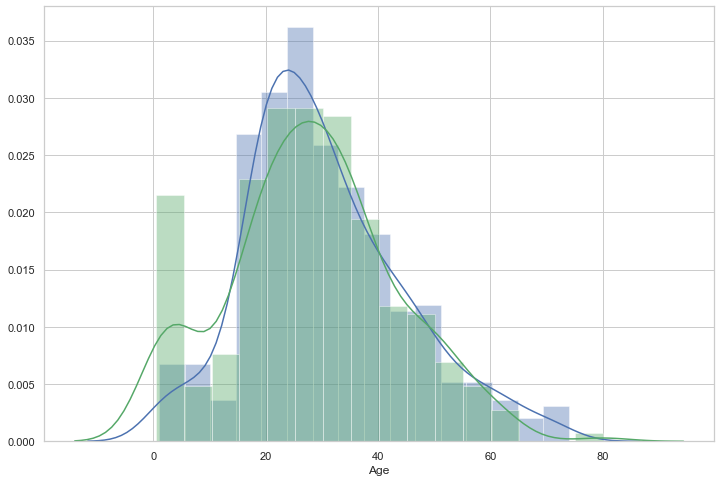

<Figure size 864x576 with 0 Axes>

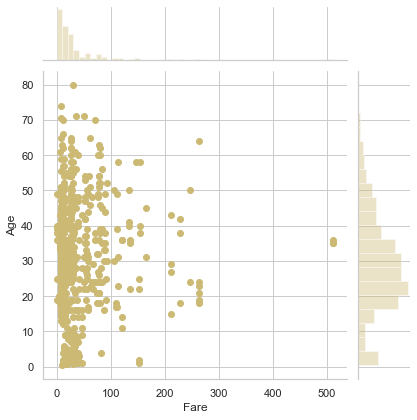

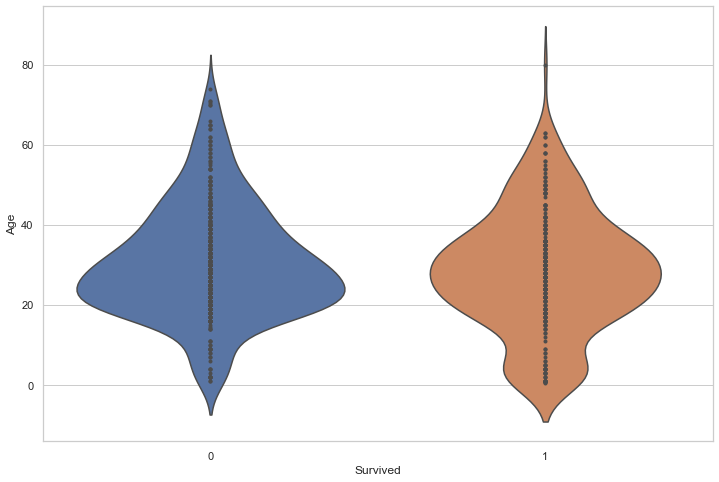

invalid value encountered in greater_equal
invalid value encountered in less_equal


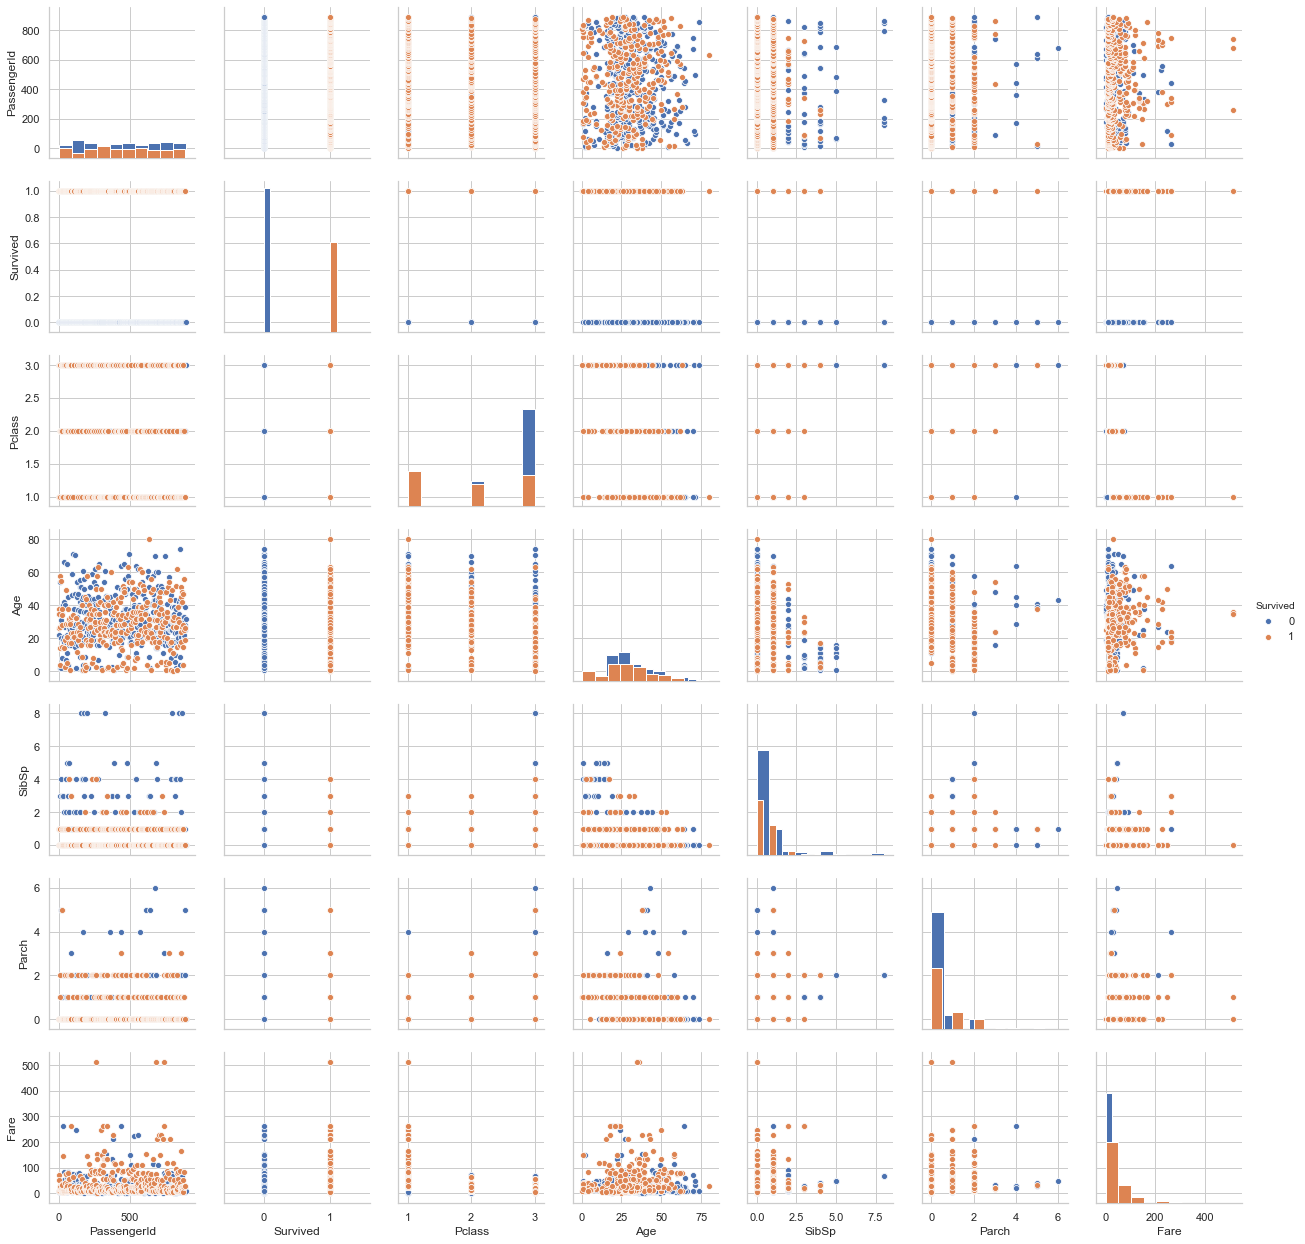

In [17]:
import seaborn as sns
target_feature = df_features.get_target_feature()
i = 0
colors = ["b", "g", "y", "black"]
plt.close()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
for target_val in df[target_feature].dropna().value_counts().index:
    sns.distplot(df["Age"].dropna()[df[target_feature].dropna() == target_val], color=colors[i])
    i += 1
plt.show()

plt.close()

plt.figure(figsize=(12, 8))
sns.barplot(
            df[target_feature],
            df["Pclass"],
            label="Total",
            color="b")
plt.close()

plt.figure(figsize=(12, 8))
sns.jointplot(df["Fare"],df["Age"], color=colors[i])
plt.show()
plt.close()

plt.figure(figsize=(12, 8))
# Show each distribution with both violins and points
sns.violinplot(df[target_feature], df["Age"], inner="points")
plt.show()
plt.close()


sns.pairplot(df[[feature_name for feature_name in df.columns if feature_name not in df_features.get_string_features()]], hue=f"{target_feature}", diag_kind='hist')

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


Text(0.5, 0.98, 'Survived by Age')

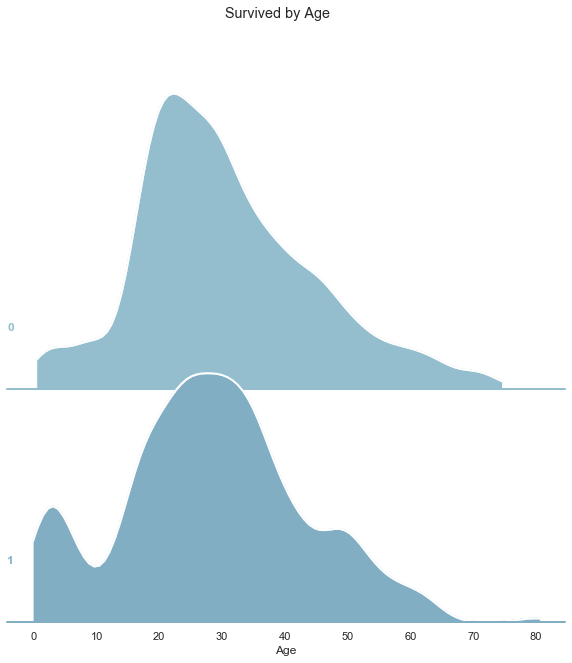

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.20, light=.7)
g = sns.FacetGrid(df,
                  row=target_feature,
                  hue=target_feature,
                  aspect=15,
                  height=.4,
                  palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot,
      "Age",
      clip_on=False,
      shade=True,
      alpha=1,
      lw=1.5,
      bw=.2)
g.map(sns.kdeplot,
      "Age",
      clip_on=False,
      color="w",
      lw=2,
      bw=.2)

g.map(plt.axhline,
      y=0,
      lw=2,
      clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2,
            label,
            fontweight="bold",
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes)


g.map(label, "Age")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.set_size_inches(10, 10, forward=True)
g.fig.suptitle(f'{target_feature} by Age')

# Data Cleaning

In [ ]:
# import datawig

# df_train, df_test = datawig.utils.random_split(df)

# #Initialize a SimpleImputer model
# imputer = datawig.SimpleImputer(
#     input_columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin','Embarked'], # column(s) containing information about the column we want to impute
#     output_column= 'Age', # the column we'd like to impute values for
#     output_path = 'imputer_model' # stores model data and metrics
#     )

# #Fit an imputer model on the train data
# imputer.fit(train_df=df, num_epochs=200)

In [ ]:
# imputed_training=mice(df[df_features.get_numerical_features()].values)

# Analysis of feature data

In [ ]:
feature_analysis = FeatureAnalysis(project_sub_dir=pre_processing_name)
feature_analysis.perform_analysis(df,
                                  df_features,
                                  dataset_name=dataset_name)
del feature_analysis

# Start test modeling

In [ ]:
import random

test = copy.deepcopy(df)
test = test.dropna(axis='columns')
test["Sex"] = df["Sex"] == "female"
y = test[target_feature].values
X = test.drop(columns=[target_feature]).values

print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.80, random_state=517, stratify=y,
)

In [ ]:
display(set(y_train))
set(y_test)

In [ ]:
# Find best parameters for model
param_grid = {
    "max_depth": list(range(1, 4)),
#     "min_samples_leaf": list(range(80, 130, 5)),
#     "criterion": ["gini", "entropy"],
#     "n_splits": [20, 30]
}

model, best_params = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    scoring="f1_micro"
)

In [ ]:
dt_model_analysis = ClassificationAnalysis(model=model,
                                           model_name=repr(model).split("(")[0],
                                           target_feature=target_feature,
                                           pred_funcs_dict={"Probabilities function":model.predict_proba,
                                                            "Predict function":model.predict},
                                           sample_data=X_train[0],
                                           project_sub_dir=f'{post_processing_name}/Classification Analysis',
                                           notebook_mode=notebook_mode,
                                           df_features=df_features)

In [ ]:
dt_model_analysis.perform_analysis(X=X_train,
                                   y=y_train,
                                   dataset_name="Train Data",
                                   thresholds_matrix=[[.0,.0],])

In [ ]:
dt_model_analysis.perform_analysis(X=X_test,
                                   y=y_test,
                                   dataset_name="Test Data",
                                   thresholds_matrix=[[.0,.0],])

In [ ]:
from eflow._hidden.utils.meta_data_identity import check_create_metadata_of_dataframe
testing_path = "/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eflow Data/Pre processing/Missing Data/All Data"
check_create_metadata_of_dataframe(df,
                                   testing_path)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, model.predict(X_test), average='micro')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model.predict(X_test), normalize=True)